In [1]:
%load_ext lab_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def prioritize_summary(df, q, covar, q_width=0.025, threshold=0, verbose=False):
    df = df.copy()

    if len(df[covar].unique()) > 5:
        df["covar_q"] = pd.qcut(df[covar], q=5).cat.codes
    else:
        df["covar_q"] = df[covar].values

    overall_predstd = np.sqrt(np.mean((df["pheno"] - df["cal_pred"]) ** 2))
    df["generic_prob"] = stats.norm.cdf((df["cal_pred"] - threshold) / overall_predstd)
    df["cal_prob"] = stats.norm.cdf((df["cal_pred"] - threshold) / df["cal_predstd"])
    df_stats = {"group": [], "generic": [], "cal": []}
    for strata in ["overall"] + list(np.sort(df["covar_q"].unique())):
        if strata == "overall":
            df_tmp = df
        else:
            df_tmp = df[df["covar_q"] == strata]

        df_tmp_generic = df_tmp[
            df_tmp["generic_prob"].between(q - q_width, q + q_width)
        ]
        df_tmp_cal = df_tmp[df_tmp["cal_prob"].between(q - q_width, q + q_width)]
        generic_prob = np.mean(df_tmp_generic["pheno"] > threshold)
        cal_prob = np.mean(df_tmp_cal["pheno"] > threshold)
        if verbose:
            print(
                f"# {strata:<8}: generic: {generic_prob * 100:.1f}% (#indiv={len(df_tmp_generic)}); cal: {cal_prob * 100:.1f}% (#indiv={len(df_tmp_cal)})"
            )
        df_stats["group"].append(strata)
        df_stats["generic"].append(generic_prob)
        df_stats["cal"].append(cal_prob)
    df_stats = pd.DataFrame(df_stats)
    return df_stats.set_index("group")


def reference_summary(df, covar, q=0.9):
    """
    use reference range
    """
    df = df.copy()

    if len(df[covar].unique()) > 5:
        df["covar_q"] = pd.qcut(df[covar], q=5).cat.codes
    else:
        df["covar_q"] = df[covar].values

    overall_threshold = df["pheno"].quantile(q=q)
    personalized_threshold = df["cal_pred"] + df["cal_predstd"] * stats.norm.ppf(q)
    df_stats = {"group": [], "overall": [], "personalized": []}
    for method in ["overall", "personalized"]:
        if method == "overall":
            threshold = overall_threshold
        else:
            threshold = personalized_threshold

        for strata in ["overall"] + list(np.sort(df["covar_q"].unique())):
            if strata == "overall":
                df_tmp = df[df["pheno"] > threshold]
            else:
                df_tmp = df[(df["covar_q"] == strata) & (df["pheno"] > threshold)]

            print(f"# {method} {strata} {len(df_tmp)}")


def rank_summary(df, q, n_indiv=1000):
    df = df.copy()
    threshold = df["pheno"].quantile(q=q)
    df["pheno_threshold"] = (df["pheno"] > threshold).astype(int)
    df["pred_z"] = (df["cal_pred"] - threshold) / df["cal_predstd"]

    z_stat = (
        df.sort_values("pred_z", ascending=False)["pheno_threshold"]
        .cumsum()
        .iloc[0:n_indiv]
    )
    point_stat = (
        df.sort_values("cal_pred", ascending=False)["pheno_threshold"]
        .cumsum()
        .iloc[0:n_indiv]
    )
    return pd.DataFrame({"prob": z_stat.values, "point": point_stat.values})

In [3]:
# setup (so this notebook can be run for trait-group repeatedly)
group = "all"
method = "mean+var"

trait = "LDL"
threshold = 175.0
covar = "PC1"

# trait = "height"
# threshold = 0.5
# covar = "PC1"

In [4]:
df_stats = []
for seed in range(1, 31):
    df = pd.read_csv(
        f"../calibrate/out/model/{trait}-{group}/{seed}-{method}.test_info.tsv",
        sep="\t",
        index_col=0,
    )
    # predictive check
    # df["pheno"] = np.random.normal(loc=df["cal_pred"], scale=df["cal_predstd"])
    df_stats.append(
        prioritize_summary(df, q=0.8, covar=covar, threshold=threshold, verbose=False)
    )
df_stats_mean = pd.DataFrame(
    np.mean(df_stats, axis=0), index=df_stats[0].index, columns=df_stats[0].columns
)
df_stats_std = pd.DataFrame(
    np.std(df_stats, axis=0) / np.sqrt(len(df_stats)),
    index=df_stats[0].index,
    columns=df_stats[0].columns,
)

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


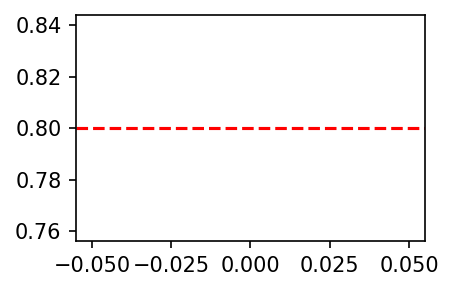

In [5]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
for i, col in enumerate(["generic", "cal"]):
    mean, std = df_stats_mean[col], df_stats_std[col]
    ax.errorbar(
        np.arange(len(mean)) - 0.2 + 0.4 * i, mean, yerr=std, fmt=".", capsize=4
    )
ax.axhline(y=0.8, ls="--", color="red")

In [37]:
df_rank = []
for seed in range(1, 31):
    df = pd.read_csv(
        f"../calibrate/out/model/{trait}-{group}/{seed}-{method}.test_info.tsv",
        sep="\t",
        index_col=0,
    )
    df = df.loc[(df.AGE < -1.5) | (df.AGE > 1.5), :]
    # predictive check
    df["pheno"] = np.random.normal(loc=df["cal_pred"], scale=df["cal_predstd"])
    df_rank.append(rank_summary(df, q=0.8, n_indiv=300))
df_rank_mean = pd.DataFrame(
    np.mean(df_rank, axis=0), index=df_rank[0].index, columns=df_rank[0].columns
)
df_rank_std = pd.DataFrame(
    np.std(df_rank, axis=0) / np.sqrt(len(df_rank)),
    index=df_rank[0].index,
    columns=df_rank[0].columns,
)

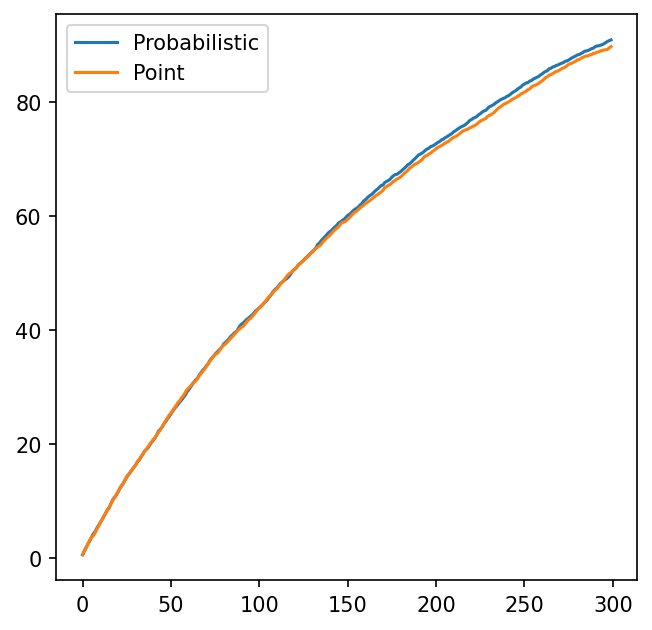

In [38]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
ax.plot(df_rank_mean["prob"], label="Probabilistic")
ax.plot(df_rank_mean["point"], label="Point")
ax.legend()

In [80]:
threshold = 3.2
overall_predstd = np.sqrt(np.mean((df["pheno"] - df["cal_pred"]) ** 2))
df["generic_prob"] = stats.norm.cdf((df["cal_pred"] - threshold) / overall_predstd)
q, q_width = 0.9, 0.05
for q in np.linspace(0, 1, 11):
    df_tmp = df[df["generic_prob"].between(q - q_width, q + q_width)]
    print(
        f"q={q}, #indiv={len(df_tmp)}, prop={np.mean(df_tmp['pheno'] > threshold):.3f}"
    )

q=0.0, #indiv=5000, prop=0.001
q=0.1, #indiv=0, prop=nan
q=0.2, #indiv=0, prop=nan
q=0.30000000000000004, #indiv=0, prop=nan
q=0.4, #indiv=0, prop=nan
q=0.5, #indiv=0, prop=nan
q=0.6000000000000001, #indiv=0, prop=nan
q=0.7000000000000001, #indiv=0, prop=nan
q=0.8, #indiv=0, prop=nan
q=0.9, #indiv=0, prop=nan
q=1.0, #indiv=0, prop=nan


In [79]:
df["pheno"].between(
    df["cal_pred"] - df["cal_predstd"] * 1.645,
    df["cal_pred"] + df["cal_predstd"] * 1.645,
).mean()

0.9036

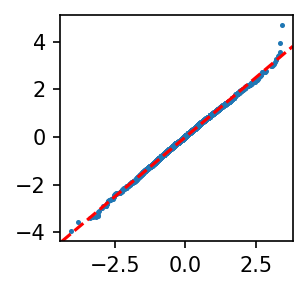

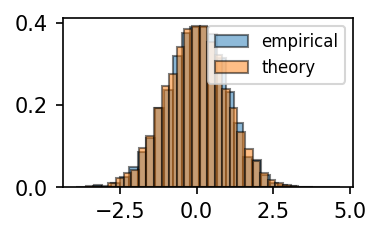

In [78]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
ax.scatter(
    np.sort(np.random.normal(size=len(df))),
    np.sort((df["pheno"] - df["cal_pred"]) / df["cal_predstd"]),
    s=2,
)
ax.axline((0, 0), slope=1, color="red", ls="--")
fig.show()

fig, ax = plt.subplots(figsize=(2.5, 1.5), dpi=150)
ax.hist(
    (df["pheno"] - df["cal_pred"]) / df["cal_predstd"],
    bins=30,
    edgecolor="black",
    linewidth=1.0,
    alpha=0.5,
    label="empirical",
    density=True,
)
ax.hist(
    np.random.normal(size=len(df)),
    bins=30,
    edgecolor="black",
    linewidth=1.0,
    alpha=0.5,
    label="theory",
    density=True,
)
ax.legend(fontsize=8)
fig.show()

# advantage of using prediction intervals

## prioritize individuals
- method 1: use point predictions (equivalently, use generic intervals) to prioritize individuals
- method 2: use point predictions + prediction intervals to priortize individuals

Goal (theory / ideal): prioritize individuals with phenotype > 3 with 90% confidence

## personalized reference range
- method 1: outlier individuals based on generic reference range (or we could add age-specific reference range)
- method 2: outlier individuals based on personalized reference range

# Fast simulations

- $y = \mathcal{N}(\widehat{y}, \sigma^2(c))$
- $\sigma^2(c) = 1$ for female; $\sigma^2(c) = 5$ for male.

In [439]:
from scipy import stats

In [440]:
n_indiv = 100000

In [441]:
covar = np.random.randint(2, size=n_indiv)
yhat = np.random.normal(size=n_indiv)
sigma2 = np.ones(n_indiv) * 0.5
sigma2[covar == 1] = 2.5
predstd = np.sqrt(sigma2)
y = yhat + np.random.normal(scale=predstd)

In [442]:
df = pd.DataFrame({"pheno": y, "cal_pred": yhat, "sex": covar, "cal_predstd": predstd})

In [443]:
prioritize_summary(df=df, q=0.9, covar="sex")

,generic,cal
group,,
overall,0.908914,0.901578
0,0.982567,0.907640
1,0.834795,0.887184


In [444]:
reference_summary(df=df, covar="sex")

# overall overall 10000
# overall 0 2791
# overall 1 7209
# personalized overall 9854
# personalized 0 4996
# personalized 1 4858


# Fast simulations end
-----

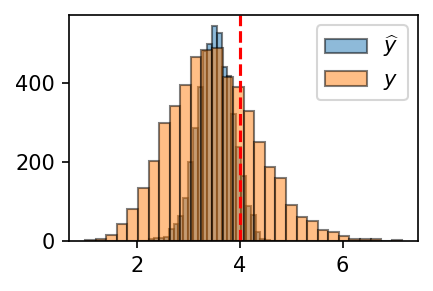

In [46]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
ax.hist(
    df["cal_pred"],
    bins=30,
    edgecolor="black",
    linewidth=1.0,
    alpha=0.5,
    label=r"$\widehat{y}$",
)
ax.hist(df["pheno"], bins=30, edgecolor="black", linewidth=1.0, alpha=0.5, label=r"$y$")
ax.axvline(x=threshold, color="red", ls="--")
ax.legend()

(array([0.16033521, 0.10689014, 0.32067041, 0.42756055, 0.64134083,
        0.16033521, 0.42756055, 0.37411548, 0.32067041, 0.16033521]),
 array([2.25  , 2.5726, 2.8952, 3.2178, 3.5404, 3.863 , 4.1856, 4.5082,
        4.8308, 5.1534, 5.476 ]),
 <BarContainer object of 10 artists>)

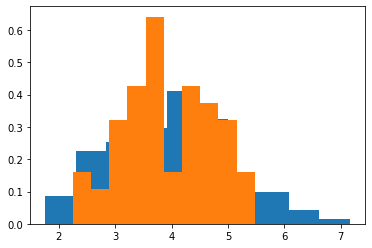

In [58]:
plt.hist(df[(df["cal_pred"] > threshold) & (df["AGE"] > 1)]["pheno"], density=True)
plt.hist(df[(df["cal_pred"] > threshold) & (df["AGE"] < -1)]["pheno"], density=True)

In [54]:
df[(df["cal_pred"] > threshold) & (df["AGE"] < -1)]["pheno"].var()

0.6650565859044163

In [4]:
# prioritize by PGS